<a href="https://colab.research.google.com/github/darkginka/Diet-Recommanded-System/blob/main/DRS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project Start**

In [121]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [122]:
import pandas as pd

In [123]:
####### dataset #######
food_nutrition = pd.read_csv("/content/drive/MyDrive/dataset/food_nutrition.csv")
disease_nutrition = pd.read_csv("/content/drive/MyDrive/dataset/disease_nutrition.csv",encoding='unicode_escape')

In [124]:
#food_nutrition.info()
food_nutrition.head()

,Category,Description,NutrientDataBankNumber,Carotene,Cryptoxanthin,Carbohydrate,Cholesterol,Choline,Fiber,Lutein and Zeaxanthin,...,Phosphorus,Potassium,Sodium,Zinc,Vitamin_A,Vitamin_B12,Vitamin_B6,Vitamin_C,Vitamin_E,Vitamin_K
0,Milk,"Milk, human",11000000,7,0,6.89,14,16.0,0.0,0,...,14,51,17,0.17,61,0.05,0.011,5.0,0.08,0.3
1,Milk,"Milk, NFS",11100000,4,0,4.87,8,17.9,0.0,0,...,103,157,39,0.42,59,0.56,0.060,0.1,0.03,0.2
2,Milk,"Milk, whole",11111000,7,0,4.67,12,17.8,0.0,0,...,101,150,38,0.41,32,0.54,0.061,0.0,0.05,0.3
3,Milk,"Milk, low sodium, whole",11111100,7,0,4.46,14,16.0,0.0,0,...,86,253,3,0.38,29,0.36,0.034,0.9,0.08,0.3
4,Milk,"Milk, calcium fortified, whole",11111150,7,0,4.67,12,17.8,0.0,0,...,101,150,38,0.41,32,0.54,0.061,0.0,0.05,0.3


In [125]:
disease_nutrition.info()
# disease_nutrition.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   disease_id             92 non-null     int64 
 1   disease                92 non-null     object
 2   ineficient_nutritions  92 non-null     object
 3   Precaution_1           92 non-null     object
 4   Precaution_2           84 non-null     object
 5   Precaution_3           65 non-null     object
 6   Precaution_4           41 non-null     object
dtypes: int64(1), object(6)
memory usage: 5.2+ KB


**Part-1**

In [126]:
####### Methods #######
def get_disease(disease_name):
	if(disease_name not in list(disease_nutrition["disease"])):
		return False
	else:
		return disease_nutrition[disease_nutrition.disease==disease_name]["disease"].values[0]

def get_disease_id(disease):
	return disease_nutrition[disease_nutrition.disease == disease]["disease_id"].values[0]

def get_disease_ie(disease):
	return disease_nutrition[disease_nutrition.disease == disease]["ineficient_nutritions"].values[0]

In [252]:
####### get-set Data #######
users_disease = input("Enter Disease Name: ")
disease_name = get_disease(users_disease)
if(disease_name==False):
  print("Disease Not Found")
else:
  disease_id = get_disease_id(disease_name)
  i= disease_id-101
  fd= disease_nutrition.iloc[i]
  pre_list = [fd["Precaution_1"],fd["Precaution_2"],fd["Precaution_3"],fd["Precaution_4"]]
  print("Precauctions: ",pre_list)         
  disease_ie = get_disease_ie(disease_name)
  dis_list = list(disease_ie.split(" "))
  for ele in dis_list:
    if(ele==""):
      dis_list.remove(ele)
  print("Ineficient Nnutritions: ",dis_list)

Enter Disease Name: acne
Precauctions:  ['bath twice', 'avoid fatty spicy food', 'drink plenty of Water', 'avoid too many products']
Ineficient Nnutritions:  ['SaturatedFat', 'Fiber', 'Riboflavin', 'Vitamin_A', 'Zinc', 'Vitamin_D', 'Vitamin_E']


**Part-2**

In [253]:
import seaborn as sns
import matplotlib.pyplot as plt

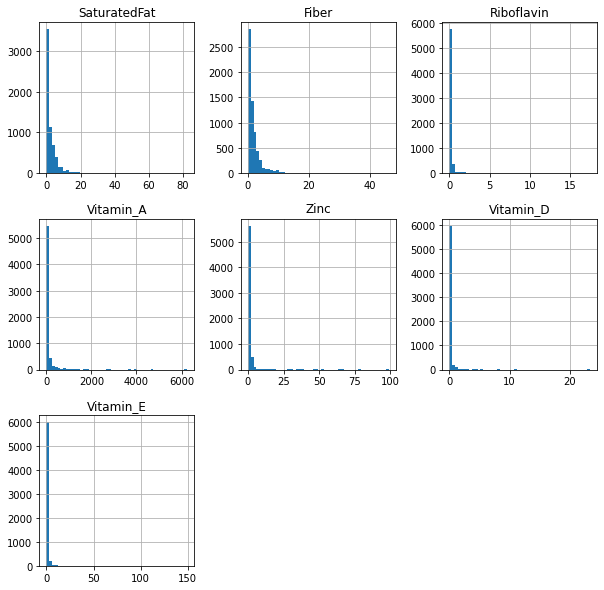

In [254]:
food_nutrition[dis_list].hist(bins=50, figsize=(10,10))
plt.show()

**Preprocessing data**

In [255]:
from sklearn.preprocessing import MinMaxScaler

In [256]:
columns_to_cluster = dis_list

In [257]:
#MinMaxScaler
#Transform features by scaling each feature to a given range.Here is an example to scale a data matrix to the [0, 1] range:
mms = MinMaxScaler()
food_scaled = mms.fit_transform(food_nutrition[columns_to_cluster])
print("Scaled Food Value: ", food_scaled[0,:])

Scaled Food Value:  [0.02435152 0.         0.00205714 0.0097522  0.0017196  0.00059893
 0.00053548]


In [258]:
columns_to_cluster_scaled = dis_list

In [259]:
df_food_scaled = pd.DataFrame(food_scaled, columns=columns_to_cluster_scaled)

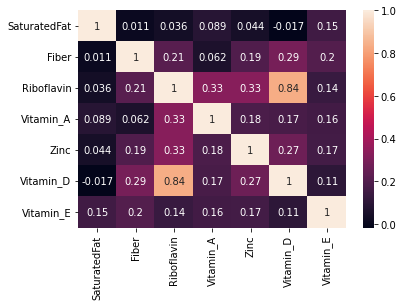

In [260]:
ax = sns.heatmap(df_food_scaled.corr(), annot=True)
plt.show()

**Training the model**

In [261]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [262]:
n_clusters = range(2,21)
ssd = []
sc = []
dict={}
for n in n_clusters:
    km = KMeans(n_clusters=n, max_iter=300, n_init=10, init='k-means++', random_state=42)
    km.fit(food_scaled)
    preds = km.predict(food_scaled) 
    centers = km.cluster_centers_ 
    ssd.append(km.inertia_) 
    score = silhouette_score(food_scaled, preds, metric='euclidean')
    sc.append(score)
#calculate the goodness of a clustering
    print("Number of Clusters = {}, Silhouette Score = {}".format(n, score))
    dict[n] = score


Number of Clusters = 2, Silhouette Score = 0.6323501656425353
Number of Clusters = 3, Silhouette Score = 0.5883435112707048
Number of Clusters = 4, Silhouette Score = 0.5958672549990905
Number of Clusters = 5, Silhouette Score = 0.5421756748924406
Number of Clusters = 6, Silhouette Score = 0.3933382110515812
Number of Clusters = 7, Silhouette Score = 0.4030905206718632
Number of Clusters = 8, Silhouette Score = 0.36280266075311857
Number of Clusters = 9, Silhouette Score = 0.3639610502373998
Number of Clusters = 10, Silhouette Score = 0.3743216120814354
Number of Clusters = 11, Silhouette Score = 0.37576417736469303
Number of Clusters = 12, Silhouette Score = 0.3849572125930139
Number of Clusters = 13, Silhouette Score = 0.3076206527886597
Number of Clusters = 14, Silhouette Score = 0.303461337098808
Number of Clusters = 15, Silhouette Score = 0.30896828324444237
Number of Clusters = 16, Silhouette Score = 0.3113928218474605
Number of Clusters = 17, Silhouette Score = 0.305259033166040

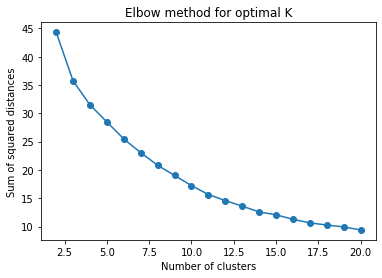

In [263]:
plt.plot(n_clusters, ssd, marker='.', markersize=12)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow method for optimal K')
plt.show()

In [264]:
# kk=[]
# kk.clear()
# for i in range(len(sc)-1):
#   kk.append(sc[i]-sc[i+1])
# k=kk.index(max(kk))+3

In [265]:
model = KMeans(n_clusters=7, random_state=42).fit(food_scaled)
pred = model.predict(food_scaled)
# print(pred)
# print(model.labels_)
print('10 first clusters: ', model.labels_[:10])

10 first clusters:  [0 0 0 0 0 0 0 0 0 0]


**Visualizing the clusters**

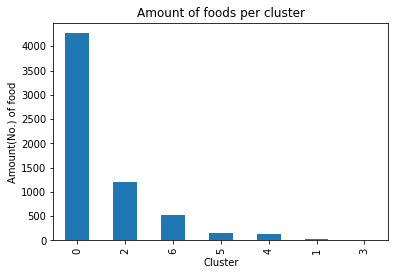

In [266]:
df_food_scaled['cluster'] = model.labels_
df_food_scaled['cluster'].value_counts().plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Amount(No.) of food')
plt.title('Amount of foods per cluster')
plt.show()

In [267]:
display(df_food_scaled['cluster'].value_counts())
minor_cluster = df_food_scaled['cluster'].value_counts().tail(1)
print("Amount of food in the smallest cluster: ", int(minor_cluster.values))

0    4266
2    1204
6     531
5     150
4     133
1      36
3      12
Name: cluster, dtype: int64

Amount of food in the smallest cluster:  12


In [268]:
df_food_joined = pd.concat([food_nutrition,df_food_scaled], axis=1).set_index('cluster')

for cluster in range(k):
    display(df_food_joined.loc[cluster, ['Description']].sample(frac=1).head(10))

,Description
cluster,
0,"Chicken drumstick, sauteed, skin not eaten"
0,"Salsify, cooked"
0,"Pasta, whole grain, with tomato-based sauce, r..."
0,Roast beef sandwich
0,"Infant formula, powder, made with water, NFS (..."
0,"Tomato soup, NFS"
0,"Broccoflower, raw"
0,"Frozen daiquiri mix, from frozen concentrate, ..."
0,Tomato sandwich


,Description
cluster,
1,"Cookie, oatmeal, reduced fat, NS as to raisins"
1,"Textured vegetable protein, dry"
1,"Wheat bran, unprocessed"
1,Cereal (Barbara's Puffins)
1,Cereal (Post Bran Flakes)
1,Cereal (General Mills Fiber One Honey Clusters)
1,"Snack cake, not chocolate, with icing or filli..."
1,Cereal (General Mills Fiber One)
1,Cereal (Uncle Sam)


,Description
cluster,
2,"Icing, chocolate"
2,Chimichanga with meat
2,"Cookie, brownie, without icing"
2,"Soft taco with meat, beans, and sour cream"
2,Cheese flavored corn snacks (Cheetos)
2,"Ladoo, round ball, Asian-Indian dessert"
2,"Burrito with meat, beans, and sour cream"
2,"Cheese sandwich, reduced fat American cheese,,..."
2,"Lamb, shoulder chop, cooked, lean only eaten"


**Applying PCA to visualize the clusters**

In [269]:
from sklearn.decomposition import PCA

In [276]:
pca = PCA(n_components=2, random_state=42)
food_pca = pca.fit_transform(food_scaled)
pca.explained_variance_ratio_.sum()

0.6686053660588734

In [277]:
df_pca = pd.DataFrame(food_pca, columns=['C1', 'C2'])
df_pca['cluster'] = model.labels_
df_pca.head()

,C1,C2,cluster
0,-0.043188,-0.005549,0
1,-0.042792,-0.015531,0
2,-0.042478,-0.007604,0
3,-0.042655,-0.004148,0
4,-0.042478,-0.007604,0


In [284]:
sampled_clusters_pca = pd.DataFrame()

for c in df_pca.cluster.unique():
    df_cluster_sampled_pca = df_pca[df_pca.cluster == c].sample(n=int(minor_cluster), random_state=42)
    sampled_clusters_pca = pd.concat([sampled_clusters_pca,df_cluster_sampled_pca], axis=0)
# sampled_clusters_pca.cluster.value_counts()

In [ ]:
sns.scatterplot(x='C1', y='C2', hue='cluster', data=sampled_clusters_pca, legend="full", palette='Paired')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Clusters view using PCA')
plt.show()

**Predicting users clusters**

In [296]:
df_user_food_joined = pd.concat([food_nutrition,df_food_scaled], axis=1).set_index('cluster')
for cluster in df_food_scaled['cluster'].unique():
    display(df_user_food_joined.loc[cluster, ['Description']].sample(frac=1).head(10))

,Description
cluster,
0,Chicken in butter sauce with potatoes and vege...
0,"Almond milk, sweetened, chocolate"
0,"Yogurt, low fat milk, plain"
0,Energy drink (Rockstar)
0,"Infant formula, powder, made with plain bottle..."
0,"Rice, white, with carrots and tomatoes and/or ..."
0,Fruit leather and fruit snacks candy
0,"Yogurt, Greek, NS as to type of milk or flavor"
0,"Topping, fruit"


,Description
cluster,
2,"Pasta, whole grain, with cream sauce and seafo..."
2,"Egg omelet or scrambled egg, with cheese and m..."
2,"Pizza with pepperoni, from restaurant or fast ..."
2,Dessert dip
2,Spinach souffle
2,"Flounder, coated, fried, made with butter"
2,Egg and cheese on biscuit
2,"Chicken ""wings"" with hot sauce, from fast food..."
2,"Sweet potato and pumpkin casserole, Puerto Ric..."


,Description
cluster,
5,"Sweet potato, baked, peel eaten, made with butter"
5,Cereal (Malt-O-Meal Marshmallow Mateys)
5,"Sweet potato, baked, peel not eaten, fat added..."
5,Cereal (Kellogg's Smart Start Strong)
5,Cereal (Kellogg's Special K Fruit & Yogurt)
5,"Carrots, NS as to form, cooked"
5,Cereal (Post Golden Crisp)
5,Nutrition bar (Snickers Marathon Protein Bar)
5,Cereal (Kellogg's Special K Chocolatey Delight)


,Description
cluster,
4,Butterscotch morsels
4,Carob chips
4,"Cheese, Parmesan, hard"
4,"Cake, pound, Puerto Rican style"
4,"Cheese, Fontina"
4,"Espresso coffee beans, chocolate-covered"
4,"Dietetic or low calorie candy, chocolate covered"
4,"Cheese, goat"
4,Soybean oil


,Description
cluster,
1,"Snack cake, not chocolate, with icing or filli..."
1,Cereal (Barbara's Puffins)
1,Cereal (Post Bran Flakes)
1,"Nutritional powder mix, sugar free (Slim Fast)"
1,"Coffee substitute, dry powder"
1,Cereal (General Mills Fiber One)
1,Yeast
1,"Papad, grilled or broiled"
1,"Wheat bran, unprocessed"


,Description
cluster,
6,"Avocado, for use on a sandwich"
6,"Popcorn chips, plain"
6,"Bread, rye"
6,Cereal (General Mills Honey Nut Clusters)
6,"Crackers, saltine, multigrain"
6,"Kidney beans, from canned, reduced sodium"
6,"Popcorn, ready-to-eat packaged, other flavored"
6,"Bread, white, special formula, added fiber, to..."
6,"Muffin, English, wheat bran"


,Description
cluster,
3,"Oysters, coated, fried"
3,"Oysters, coated, baked or broiled, fat added"
3,"Oysters, raw"
3,"Oysters, canned"
3,Oyster fritter
3,"Oysters, coated, baked or broiled, no added fat"
3,Cereal (Kellogg's All-Bran Complete Wheat Flakes)
3,"Oysters, smoked"
3,"Oysters, steamed"


**Recommending Food**

In [297]:
df_user_food_joined.reset_index(inplace=True)
cluster_pct = df_user_food_joined.cluster.value_counts(normalize=True)*20

if int(cluster_pct.round(0).sum()) < 20:
    cluster_pct[cluster_pct < 0.5] = cluster_pct[cluster_pct < 0.5] + 1.0
    
display(cluster_pct)
print('Total food: ', int(cluster_pct.round(0).sum()))

0    13.474416
2     3.802906
6     1.677195
5     1.473784
4     1.420088
1     1.113708
3     1.037903
Name: cluster, dtype: float64

Total food:  23


In [298]:
df_food_joined.reset_index(inplace=True)
df_food_joined.head(3)

,cluster,Category,Description,NutrientDataBankNumber,Carotene,Cryptoxanthin,Carbohydrate,Cholesterol,Choline,Fiber,...,Vitamin_C,Vitamin_E,Vitamin_K,SaturatedFat,Fiber,Riboflavin,Vitamin_A,Zinc,Vitamin_D,Vitamin_E
0,0,Milk,"Milk, human",11000000,7,0,6.89,14,16.0,0.0,...,5.0,0.08,0.3,0.024352,0.0,0.002057,0.009752,0.001720,0.000599,0.000535
1,0,Milk,"Milk, NFS",11100000,4,0,4.87,8,17.9,0.0,...,0.1,0.03,0.2,0.014109,0.0,0.007829,0.009432,0.004248,0.002439,0.000201
2,0,Milk,"Milk, whole",11111000,7,0,4.67,12,17.8,0.0,...,0.0,0.05,0.3,0.022545,0.0,0.007886,0.005116,0.004147,0.002396,0.000335


In [299]:
df_user_food_joined['cluster_pct'] = df_user_food_joined['cluster'].apply(lambda c: cluster_pct[c])
df_user_food_joined.drop(columns=columns_to_cluster_scaled, inplace=True)
df_user_food_joined.head(3)

,cluster,Category,Description,NutrientDataBankNumber,Carotene,Cryptoxanthin,Carbohydrate,Cholesterol,Choline,Lutein and Zeaxanthin,...,Iron,Magnesium,Phosphorus,Potassium,Sodium,Vitamin_B12,Vitamin_B6,Vitamin_C,Vitamin_K,cluster_pct
0,0,Milk,"Milk, human",11000000,7,0,6.89,14,16.0,0,...,0.03,3,14,51,17,0.05,0.011,5.0,0.3,13.474416
1,0,Milk,"Milk, NFS",11100000,4,0,4.87,8,17.9,0,...,0.00,12,103,157,39,0.56,0.060,0.1,0.2,13.474416
2,0,Milk,"Milk, whole",11111000,7,0,4.67,12,17.8,0,...,0.00,12,101,150,38,0.54,0.061,0.0,0.3,13.474416


In [307]:
final_Food = pd.DataFrame()

for ncluster, pct in cluster_pct.items():
    foods = df_food_joined[df_food_joined['cluster'] == ncluster].sample(n=int(round(pct, 0)))
    final_Food = pd.concat([final_Food,foods], ignore_index=True)
    if len(final_Food) > 20 :
        flag = 20 - len(final_Food)
        final_Food = final_Food[:flag]
final_Food.head(3)

,cluster,Category,Description,NutrientDataBankNumber,Carotene,Cryptoxanthin,Carbohydrate,Cholesterol,Choline,Fiber,...,Vitamin_C,Vitamin_E,Vitamin_K,SaturatedFat,Fiber,Riboflavin,Vitamin_A,Zinc,Vitamin_D,Vitamin_E
0,0,Shrimp and vegetables including carrots,"Shrimp and vegetables including carrots, brocc...",27450410,1369,0,5.29,72,53.3,1.3,...,14.8,1.74,35.2,0.012085,0.028139,0.003200,0.027018,0.007586,0.002053,0.011647
1,0,Pretzels,"Pretzels, soft, from frozen, cinnamon sugar co...",54408460,9,2,73.99,10,14.3,2.1,...,0.1,0.55,2.8,0.034558,0.045455,0.012686,0.005116,0.007485,0.013176,0.003681
2,0,Fruit juice drink,"Fruit juice drink, with high vitamin C, plus a...",92582100,0,0,12.50,0,0.0,0.0,...,30.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [308]:
final_Food[['Description']]

,Description
0,"Shrimp and vegetables including carrots, brocc..."
1,"Pretzels, soft, from frozen, cinnamon sugar co..."
2,"Fruit juice drink, with high vitamin C, plus a..."
3,"Potato, roasted, from fresh, peel eaten, made ..."
4,Water Chesnut
5,"Sushi roll, eel"
6,"Snowpea, fresh, cooked, fat added"
7,"Pie, strawberry-rhubarb, two crust"
8,Chicken or turkey and noodles with cream or wh...
9,"Milk, fat free (skim)"


In [ ]:
list_of_foods = final_Food['Description'].to_list()
print(list_of_foods)

['Chicken or turkey and vegetables including carrots, broccoli, and/or dark-green leafy; no potatoes, gravy', 'Seven and Seven', 'Egg roll, meatless', 'Chicken or turkey, rice, and vegetables including carrots, broccoli, and/or dark-green leafy; cream sauce, white sauce, or mushroom sauce', 'Egg omelet or scrambled egg, with meat, no added fat', 'Bouillabaisse', 'Broccoli slaw salad', 'Yogurt, Greek, nonfat milk, plain', 'Bread, raisin', 'Yuca fries', 'Asparagus, NS as to form, cooked', 'Vegetable lasagna, frozen meal', 'Halibut, baked or broiled, made with cooking spray', 'Macaroni with vegetables, baby food, strained', 'Cake or cupcake, marble, with icing or filling', 'Chicken fillet wrap sandwich, fried, from fast food', 'Potato skins, with cheese', 'Toffee, chocolate-coated, with nuts', 'Kidney beans, from canned, reduced sodium', 'Popcorn, movie theater, with added butter']
